<a href="https://colab.research.google.com/github/Elm-Forest/detr_mini/blob/master/detr_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, Tensor
from torchvision.models import resnet50
import warnings
import torch.nn.functional as F
from typing import Optional, List
torch.set_grad_enabled(False);
warnings.filterwarnings('ignore') 

In [2]:
backbone = resnet50()
del backbone.fc
conv = nn.Conv2d(2048, 256, 1)

In [ ]:
inputs = torch.randn(1, 3, 800, 1200)

In [14]:
x = backbone.conv1(inputs)
x = backbone.bn1(x)
x = backbone.relu(x)
x = backbone.maxpool(x)
x = backbone.layer1(x)
x = backbone.layer2(x)
x = backbone.layer3(x)
x = backbone.layer4(x)
x.size()

torch.Size([1, 2048, 25, 34])

In [15]:
h = conv(x)
h.size()

torch.Size([1, 256, 25, 34])

In [16]:
row_embed = nn.Parameter(torch.rand(50, 256 // 2))
col_embed = nn.Parameter(torch.rand(50, 256 // 2))

In [17]:
H, W = h.shape[-2:]
pos = torch.cat([
    col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
    row_embed[:H].unsqueeze(1).repeat(1, W, 1),
], dim=-1).flatten(0, 1).unsqueeze(1)
pos.size()

torch.Size([850, 1, 256])

In [18]:
h = h.flatten(2).permute(2, 0, 1)
h.size()

torch.Size([850, 1, 256])

In [19]:
transformer_encoder_input = pos + h
transformer_encoder_input.size()

torch.Size([850, 1, 256])

In [20]:
d_model=256
nhead=8
num_encoder_layers=6
num_decoder_layers=6
dim_feedforward=2048
drop_out=0.1

In [21]:
self_attn = nn.MultiheadAttention(d_model, nhead, dropout=drop_out)
linear1 = nn.Linear(d_model, dim_feedforward)
dropout = nn.Dropout(drop_out)
linear2 = nn.Linear(dim_feedforward, d_model)
norm1 = nn.LayerNorm(d_model)
norm2 = nn.LayerNorm(d_model)
dropout1 = nn.Dropout(drop_out)
dropout2 = nn.Dropout(drop_out)
activation = F.relu

In [22]:
q = k = transformer_encoder_input
src2 = self_attn(q, k, value=h, attn_mask=None,
                      key_padding_mask=None)[0]
src2.size()

torch.Size([850, 1, 256])

In [23]:
src = h + dropout1(src2)
src = norm1(src)
src.size()

torch.Size([850, 1, 256])

In [24]:
src2 = linear2(dropout(F.relu(linear1(src))))
src2.size()

torch.Size([850, 1, 256])

In [25]:
src = src + dropout2(src2)
src = norm2(src)
src.size()

torch.Size([850, 1, 256])

In [26]:
query_pos = nn.Parameter(torch.rand(100, 256))
query_embed = query_pos.unsqueeze(1).repeat(1, 1, 1)
query_embed.size()

torch.Size([100, 1, 256])

In [27]:
tgt = torch.zeros_like(query_embed)
tgt.size()

torch.Size([100, 1, 256])

In [28]:
def with_pos_embed(tensor, pos: Optional[Tensor]):
    return tensor if pos is None else tensor + pos

In [29]:
self_attn = nn.MultiheadAttention(d_model, nhead, dropout=drop_out)
multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=drop_out)
linear1 = nn.Linear(d_model, dim_feedforward)
dropout = nn.Dropout(drop_out)
linear2 = nn.Linear(dim_feedforward, d_model)
norm1 = nn.LayerNorm(d_model)
norm2 = nn.LayerNorm(d_model)
norm3 = nn.LayerNorm(d_model)
dropout1 = nn.Dropout(drop_out)
dropout2 = nn.Dropout(drop_out)
dropout3 = nn.Dropout(drop_out)
activation = F.relu

In [30]:
q = k = with_pos_embed(tgt, query_embed)

In [31]:
tgt2 = self_attn(q, k, value=tgt, attn_mask=None,
                      key_padding_mask=None)[0]
tgt2.size()

torch.Size([100, 1, 256])

In [32]:
tgt = tgt + dropout1(tgt2)
tgt = norm1(tgt)
tgt.size()

torch.Size([100, 1, 256])

In [33]:
tgt2 = multihead_attn(query=with_pos_embed(tgt, query_embed),
                           key=with_pos_embed(src, pos),
                           value=src, attn_mask=None,
                           key_padding_mask=None)[0]
tgt2.size()

torch.Size([100, 1, 256])

In [34]:
tgt = tgt + dropout2(tgt2)
tgt = norm2(tgt)
tgt.size()

torch.Size([100, 1, 256])

In [35]:
tgt2 = linear2(dropout(activation(linear1(tgt))))
tgt2.size()

torch.Size([100, 1, 256])

In [36]:
tgt = tgt + dropout3(tgt2)
tgt = norm3(tgt)
tgt.size()

torch.Size([100, 1, 256])

In [37]:
tgt=tgt.transpose(0, 1)

In [38]:
linear_class = nn.Linear(256, 9 + 1)
linear_bbox = nn.Linear(256, 4)

In [39]:
logits, bboxes =linear_class(tgt),linear_bbox(tgt).sigmoid()

In [40]:
logits.size()

torch.Size([1, 100, 10])

In [41]:
bboxes.size()

torch.Size([1, 100, 4])

### 使用真实图片进行测试

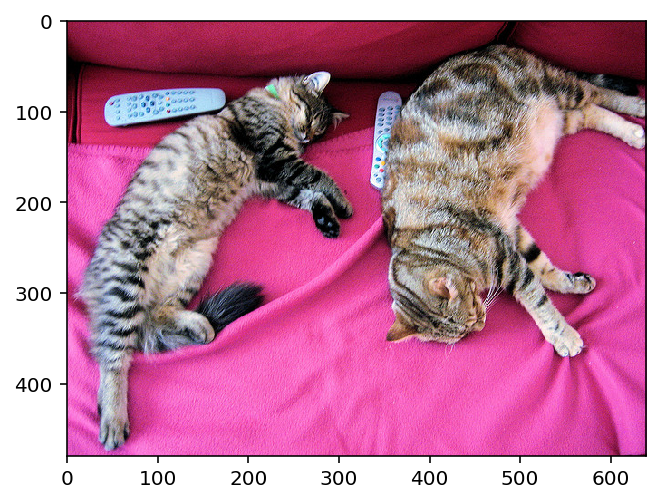

In [3]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)
import torchvision.transforms as T
torch.set_grad_enabled(False);
plt.imshow(im)

In [4]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
img = transform(im).unsqueeze(0)

assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'
img.size()

torch.Size([1, 3, 800, 1066])

In [6]:
inputs=img

**将img作为输出，重新过一遍DETR**

In [7]:
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

In [8]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [9]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [42]:
probas = logits.softmax(-1)[0, :, :-1]
probas.size()

torch.Size([100, 9])

In [43]:
confidence=0.3
keep = probas.max(-1).values > confidence

In [44]:
bboxes_scaled = rescale_bboxes(bboxes[0, keep], im.size)
bboxes_scaled.size()

torch.Size([1, 4])

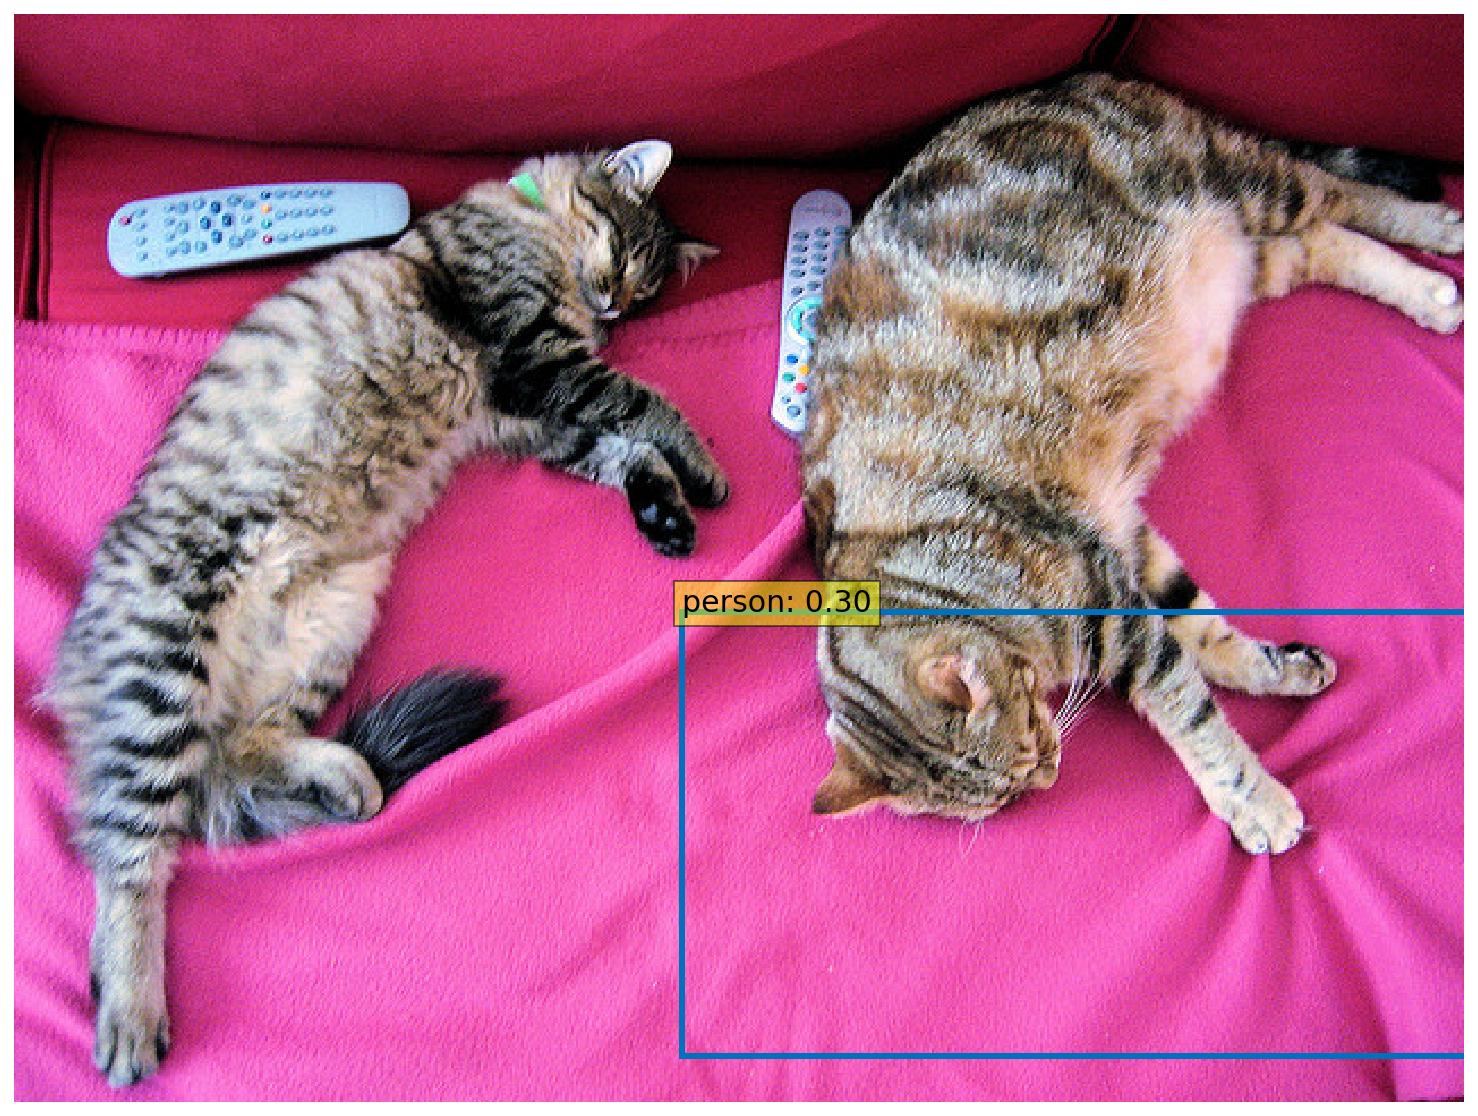

In [45]:
plot_results(im, probas[keep], bboxes_scaled)

In [46]:
print(probas[keep].size(), bboxes_scaled.size())

torch.Size([1, 9]) torch.Size([1, 4])


### 使用nn.Transformer

In [47]:
transformer=nn.Transformer(256, 8, 6, 6)

In [48]:
query_pos = nn.Parameter(torch.rand(100, 256))

In [49]:
h=transformer_out=transformer(pos + 0.1 * h,
                             query_pos.unsqueeze(1)).transpose(0, 1)
transformer_out.size()

torch.Size([1, 100, 256])

In [50]:
linear_class = nn.Linear(256, 9 + 1)
linear_bbox = nn.Linear(256, 4)

In [51]:
logits, bboxes =linear_class(h),linear_bbox(h).sigmoid()
print(logits.size(),bboxes.size())

torch.Size([1, 100, 10]) torch.Size([1, 100, 4])


In [52]:
probas = logits.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.2
bboxes_scaled = rescale_bboxes(bboxes[0, keep], im.size)

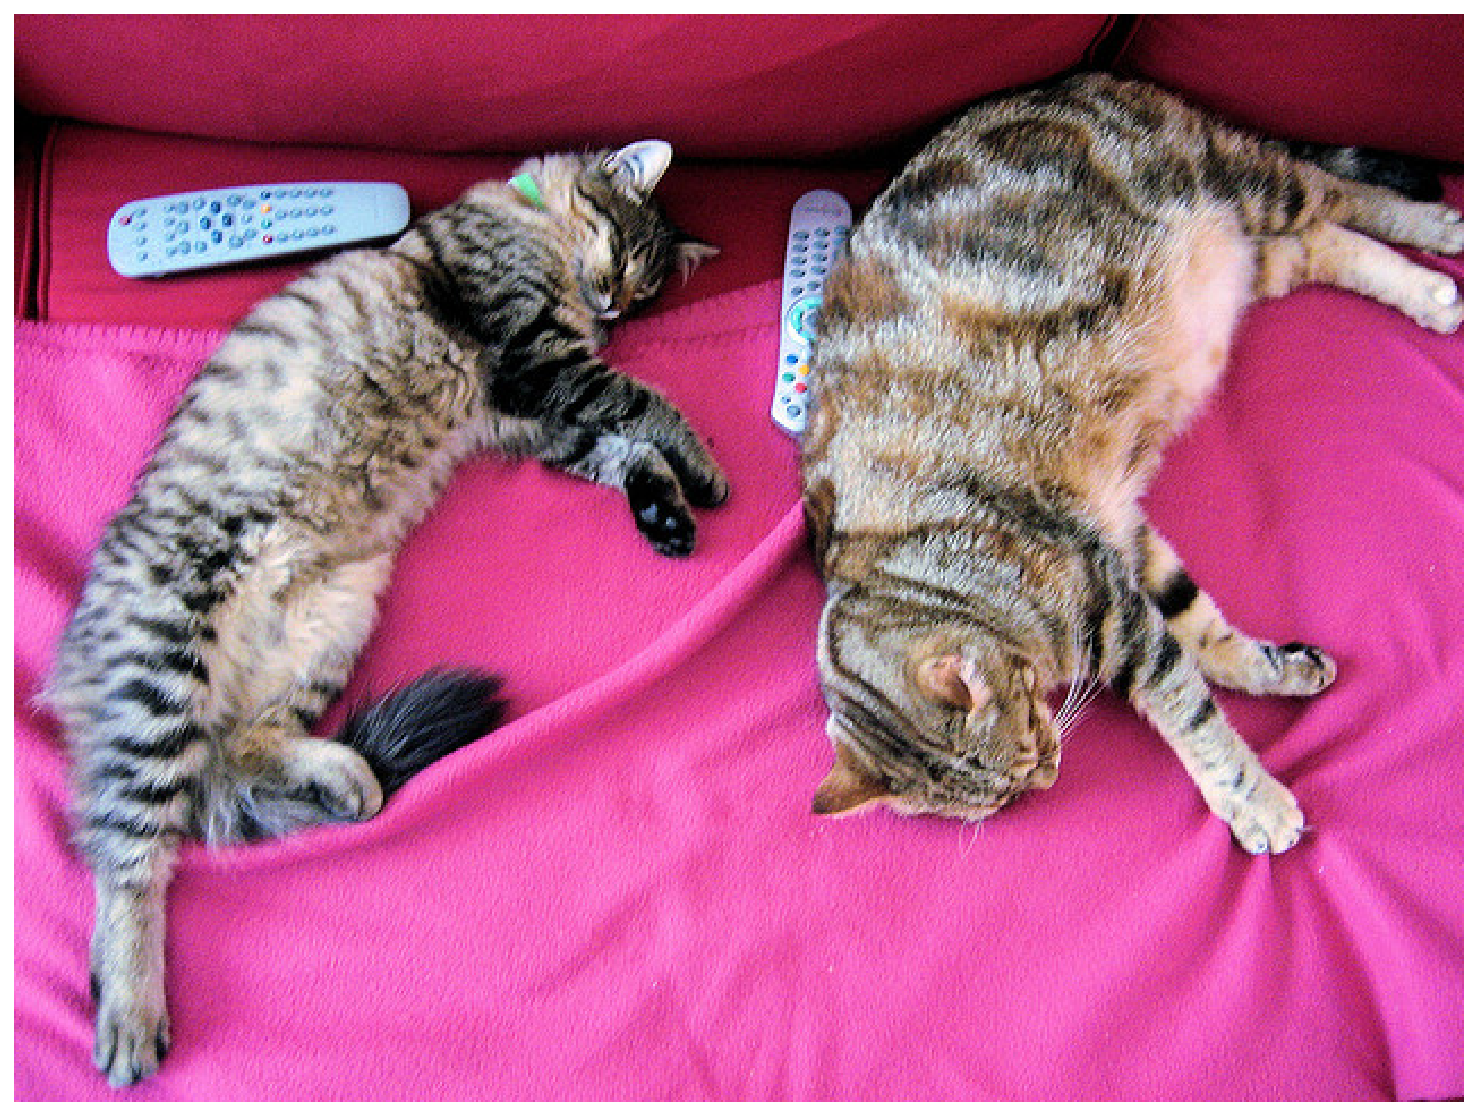

In [53]:
plot_results(im, probas[keep], bboxes_scaled)

In [ ]:
print(probas[keep].size(), bboxes_scaled.size())

torch.Size([1, 9]) torch.Size([1, 4])


### 搭建正式模型进行测试

In [82]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        # x = nn.Sequential(*list(model.backbone.children())[:-2])(inputs)
        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [83]:
detr=None
detr = DETRdemo(num_classes=91)

In [84]:
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval()
print('')

In [57]:
def detect(im, model, transform, confidence):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > confidence

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled,keep

In [58]:
scores, boxes,keep = detect(im, detr, transform,0.7)
bboxes_scaled=boxes

print(scores.size())
print(boxes.size())

torch.Size([5, 91])
torch.Size([5, 4])


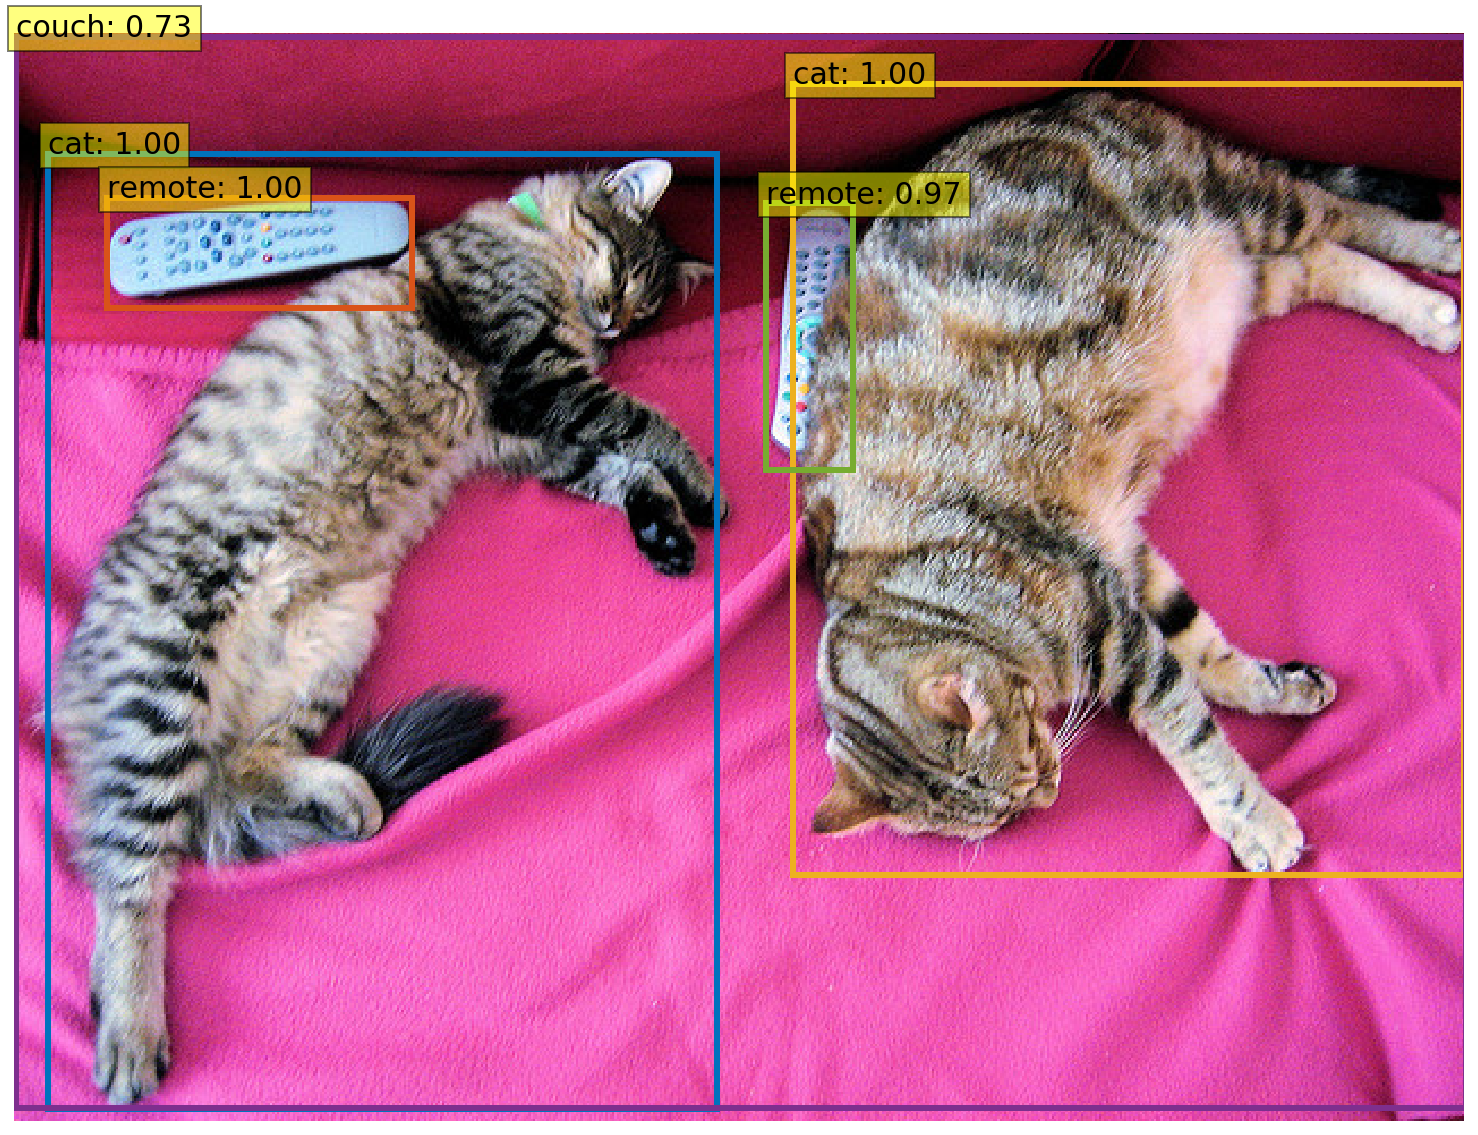

In [59]:
plot_results(im, scores, boxes)

**如果不加载权重**

In [61]:
detr=None
detr = DETRdemo(num_classes=91)
scores, boxes = detect(im, detr, transform,0.1)
print(scores.size())
print(boxes.size())
plot_results(im, scores, boxes)

ValueError: too many values to unpack (expected 2)

In [108]:
from detr_mini import DETR
detr = DETR(num_classes=91, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6)
model=detr


In [110]:
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
# model.transformer.decoder.layers[-1].self_attn.register_forward_hook

<All keys matched successfully>

In [111]:
model.transformer.encoder.layers[-1].self_attn

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
)

In [112]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone.layer2.register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# propagate through the model
outputs = model(img)

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

In [113]:
dec_attn_weights

tensor([[[9.3954e-04, 6.9799e-04, 4.0203e-04,  ..., 3.5197e-04,
          7.5681e-04, 1.0855e-02],
         [2.0359e-03, 7.5304e-04, 5.4237e-05,  ..., 3.0637e-04,
          2.4267e-04, 1.6663e-02],
         [1.3119e-03, 1.0149e-03, 2.2315e-04,  ..., 7.1877e-04,
          4.5432e-04, 1.3902e-03],
         ...,
         [7.8473e-04, 5.5791e-04, 8.5218e-05,  ..., 4.4290e-04,
          1.4695e-03, 8.9243e-03],
         [2.3112e-03, 8.8235e-04, 3.0745e-04,  ..., 2.4992e-04,
          1.6206e-03, 2.5796e-02],
         [1.8896e-03, 1.5723e-03, 4.2191e-04,  ..., 3.3822e-04,
          5.5440e-04, 2.7447e-02]]])

IndexError: index 4 is out of bounds for dimension 0 with size 1

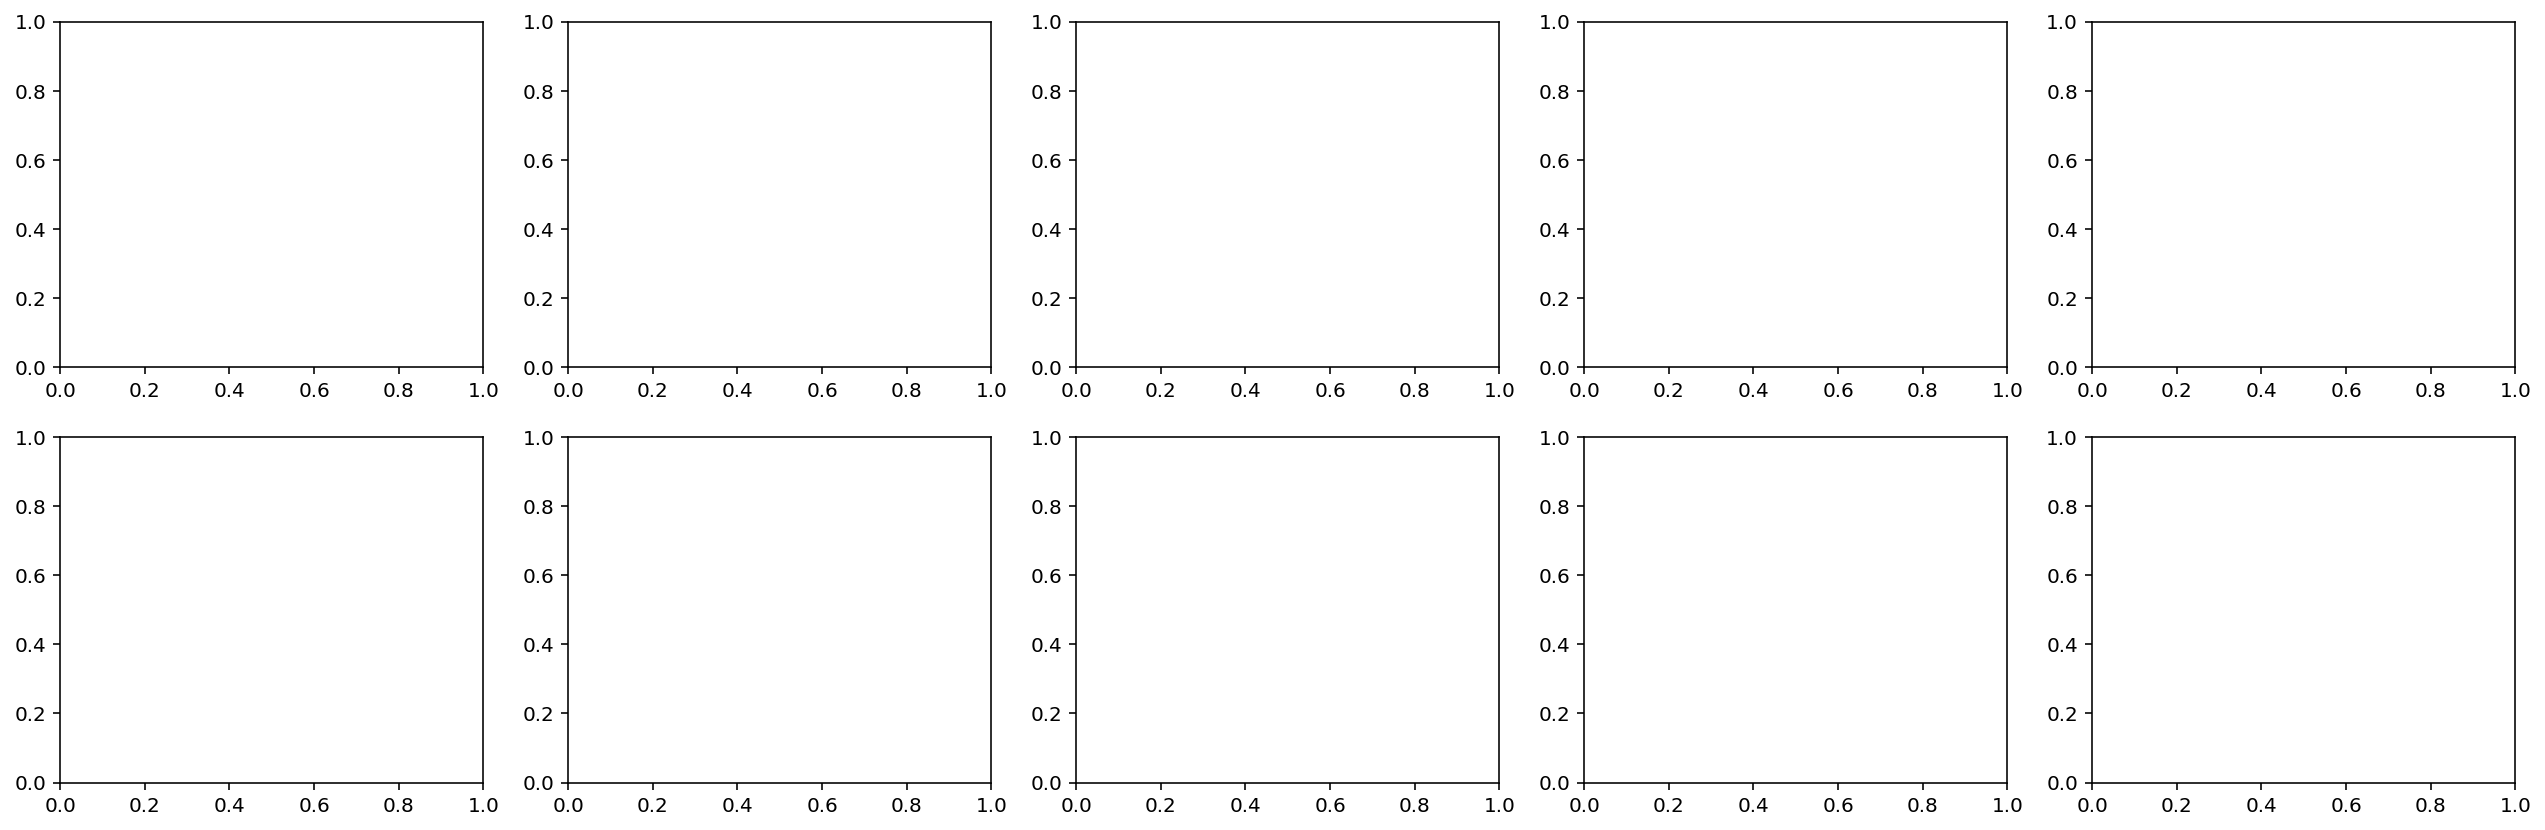

In [114]:
# get the feature map shape
h, w = conv_features[0].shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    print(dec_attn_weights[idx].size(),h,w)
    ax.imshow(dec_attn_weights[idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

torch.Size([1, 1, 256]) 100 134


RuntimeError: shape '[100, 134]' is invalid for input of size 256

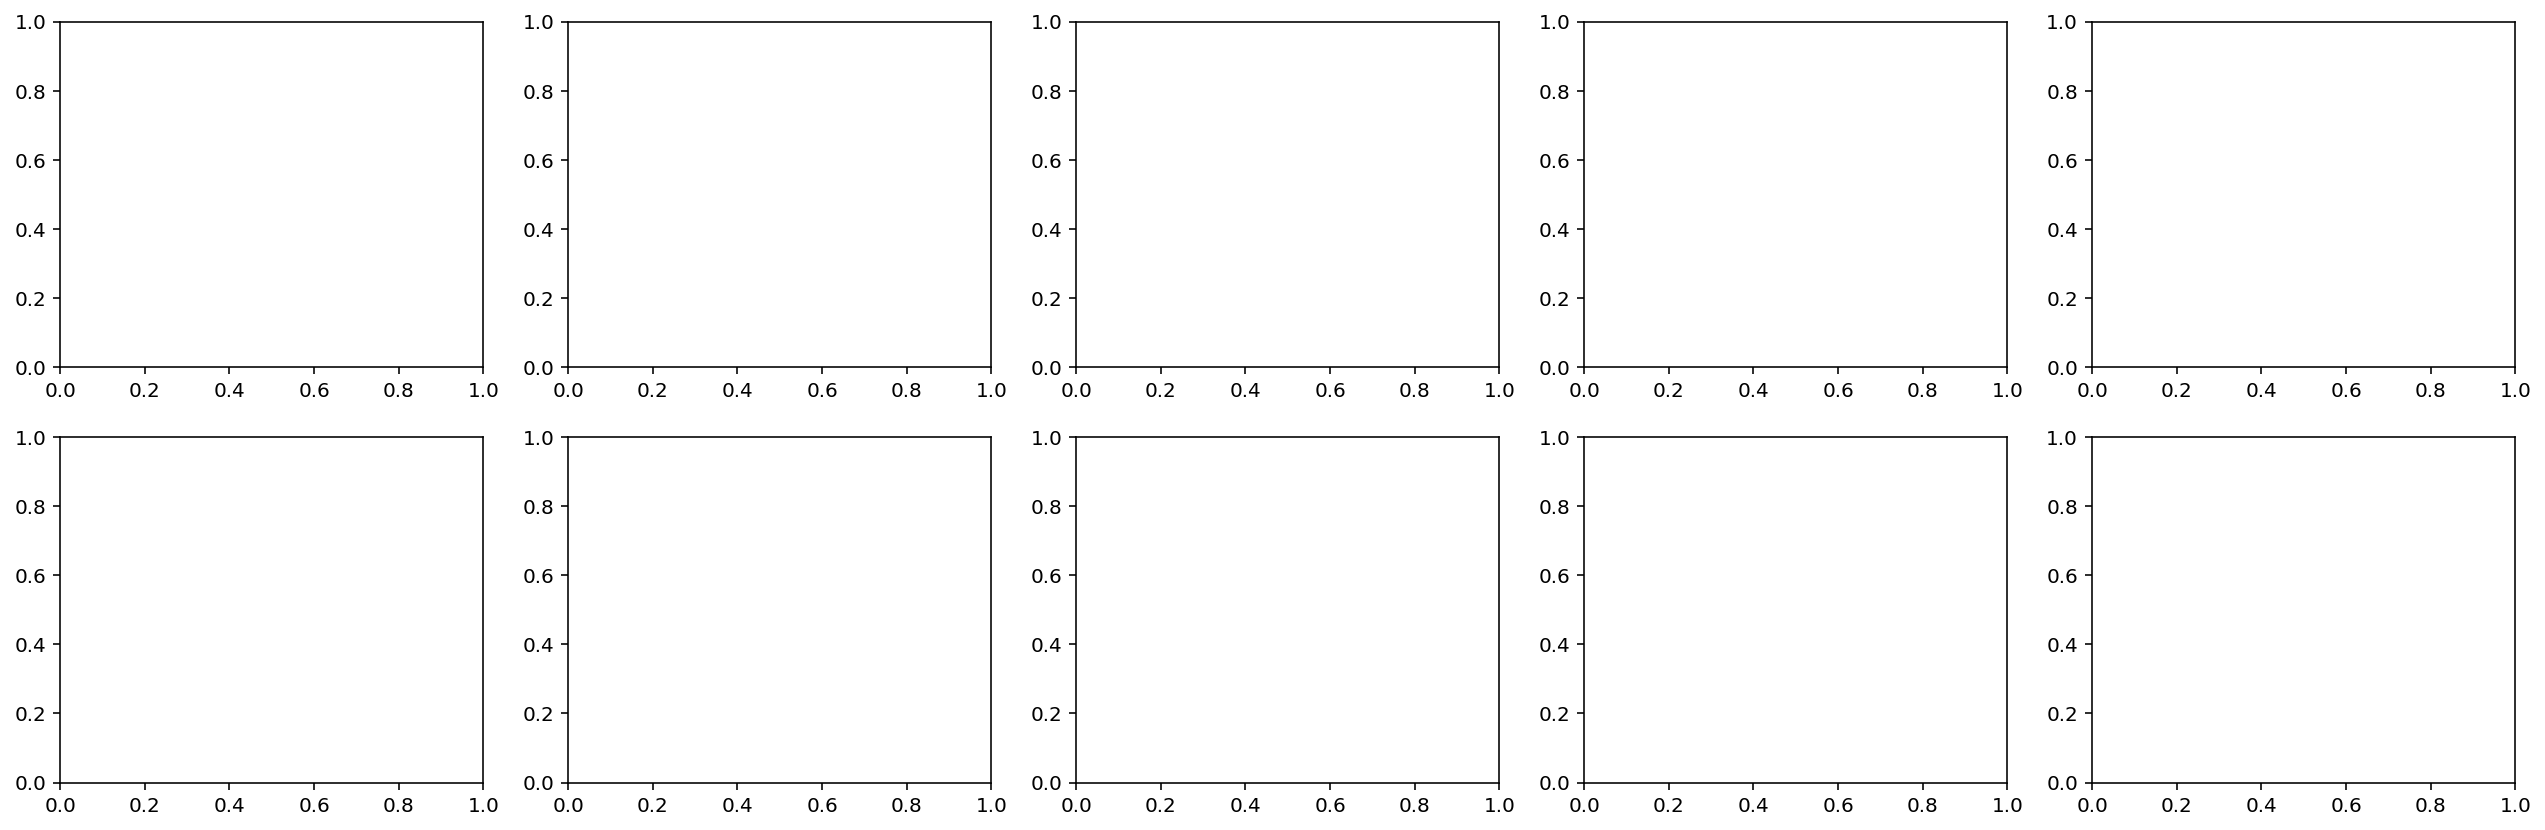

In [67]:
# get the feature map shape
h, w = conv_features[0].shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    print(dec_attn_weights[idx].size(),h,w)
    ax.imshow(dec_attn_weights[idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

In [2]:
hidden_dim=256
num_queries=100
emb=nn.Embedding(num_queries, hidden_dim)
para=nn.Parameter(torch.rand(num_queries, hidden_dim))

In [7]:
print(emb.weight.size())
print(para.size())

torch.Size([100, 256])
torch.Size([100, 256])


In [8]:
from detr_mini import DETR

detr = DETR(num_classes=91, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6)
for k,v in torch.load('E:/Development Program/Pycharm Program/detr/detr-r50-e632da11.pth')['model'].items():
    print(k)

transformer.encoder.layers.0.self_attn.in_proj_weight
transformer.encoder.layers.0.self_attn.in_proj_bias
transformer.encoder.layers.0.self_attn.out_proj.weight
transformer.encoder.layers.0.self_attn.out_proj.bias
transformer.encoder.layers.0.linear1.weight
transformer.encoder.layers.0.linear1.bias
transformer.encoder.layers.0.linear2.weight
transformer.encoder.layers.0.linear2.bias
transformer.encoder.layers.0.norm1.weight
transformer.encoder.layers.0.norm1.bias
transformer.encoder.layers.0.norm2.weight
transformer.encoder.layers.0.norm2.bias
transformer.encoder.layers.1.self_attn.in_proj_weight
transformer.encoder.layers.1.self_attn.in_proj_bias
transformer.encoder.layers.1.self_attn.out_proj.weight
transformer.encoder.layers.1.self_attn.out_proj.bias
transformer.encoder.layers.1.linear1.weight
transformer.encoder.layers.1.linear1.bias
transformer.encoder.layers.1.linear2.weight
transformer.encoder.layers.1.linear2.bias
transformer.encoder.layers.1.norm1.weight
transformer.encoder.la

In [7]:
%matplotlib inline

In [9]:
multihead_attn = nn.MultiheadAttention(256, 8, dropout=0.1)

In [10]:
import numpy as np